In [16]:
import nltk
import tagutils; reload(tagutils)
from tagutils import *
from IPython.core.display import HTML
from nltk.corpus import brown
import random as pyrand
from collections import Counter,defaultdict
from tagutils import *

# Training Data

In [2]:
sents = list(brown.tagged_sents())
pyrand.shuffle(sents)
training_set = sents[:-1000]
test_set = sents[-1000:]

# Posteriors and Conditionals

Let's start by defining some useful little functions.

In [60]:
c = Counter([1,2,3,3,3])
def posterior(c):
    """Given a `Counter`, compute an equivalent posterior (represented
    as a dictionary. This basically just normalizes."""
    n = sum(c.values())
    return {k:v*1.0/n for k,v in c.items()}
def pmax(c,default=None):
    """Given a dictionary, returns the key corresponding to the
    maximum value. Useful for finding $\arg\max_c P(c|x)$."""
    if c is None: return default
    if len(c)==0: return default
    return max([(v,k) for k,v in c.items()])[1]
print posterior(c)
print pmax(c)

{1: 0.20000000000000001, 2: 0.20000000000000001, 3: 0.59999999999999998}
3


In [137]:
class Conditional:
    """Given a set of pairs (u,v), compute
    estimates of $P(v|u)$, returning a posterior
    distribution given $u$."""
    def train(self,pairs):
        counts = defaultdict(Counter)
        for k,v in pairs:
            counts[k].update([v])
        posteriors = {}
        for k,v in counts.items():
            posteriors[k] = posterior(v)
        self.posteriors = posteriors
    def __getitem__(self,k):
        return self.posteriors.get(k,None)

With these definitions, we can trivially compute a unigram model.

In [65]:
cs = Conditional()
cs.train(brown.tagged_words()[:1000])

In [66]:
cs["to"]

{'IN': 0.2857142857142857, 'TO': 0.7142857142857143}

# A Simple "Greedy Bigram Tagger"

The simplest "bigram" tagger uses a probabilistic model (this actually isn't usually
called a "bigram tagger"; see below).

$P(T_n|W_n,W_{n-1})$

What we actually want to find is the most likely tag sequence $T_1 ...T_N$ given a
sequence of input words $W_1 ... W_N$.  Assuming that $W_i = \epsilon$ 
(some special, "empty" symbol), we can write under a Markov assumption:

$P(T_1 ... T_N | W_1 ... W_N) = \prod_i P(T_i|W_i,W_{i-1})$

The best tag sequence is the one that maximizes the posterior probability of
the entire sequence.

However, there is another question we can ask, namely what the most likely
tag is at each position. Due to the Markov property, this is really very easy 
to answer for this models since it is just given by:

$T_i = \arg\max_{T_i} P(T_i|W_i,W_{i-1})$

Note that this local tagging may not even result in a tag sequence with non-zero
probability.



In [67]:
def words(tagged):
    return [w for w,t in tagged]
def tags(tagged):
    return [t for w,t in tagged]

In [68]:
def bigrams(sent):
    sent = ['']+sent
    return zip(sent,sent[1:])

In [69]:
def sentences_bigrams(sentences):    
    for sent in sentences:
        for b in zip(bigrams(words(sent)),tags(sent)):
            yield b

In [70]:
list(sentences_bigrams(brown.tagged_sents()[:2]))[:10]

[(('', 'The'), 'AT'),
 (('The', 'Fulton'), 'NP-TL'),
 (('Fulton', 'County'), 'NN-TL'),
 (('County', 'Grand'), 'JJ-TL'),
 (('Grand', 'Jury'), 'NN-TL'),
 (('Jury', 'said'), 'VBD'),
 (('said', 'Friday'), 'NR'),
 (('Friday', 'an'), 'AT'),
 (('an', 'investigation'), 'NN'),
 (('investigation', 'of'), 'IN')]

In [71]:
bgs = Conditional()
bgs.train(sentences_bigrams(brown.tagged_sents()))

In [77]:
sent = "The man said something .".split()
bs = bigrams(sent)
print bs
ts = [pmax(bgs[b]) for b in bs]
print ts

[('', 'The'), ('The', 'man'), ('man', 'said'), ('said', 'something'), ('something', '.')]
['AT', 'NN', 'VBD', 'PN', '.']


In [78]:
def tagger1(sent):
    bs = bigrams(sent)
    ts = [pmax(bgs[b]) for b in bs]
    return zip(sent,ts)

In [83]:
HTML(stags(tagger1("The man said something .".split())))

# Recursive "Greedy" Decoding

Instead of modeling the probability distribution of a tag given previous words,
we can also model the probability distribution of a tag given the current word
and previous tags.

$P(T_i|W_i,T_{i-1})$

Let us estimate this probability distribution.

In [84]:
def tbigrams(tagged):
    ws = words(tagged)
    ts = tags(tagged)
    return zip([None]+ts,ws)

In [91]:
s = brown.tagged_sents()[0]
tbigrams(s)

[(None, 'The'),
 ('AT', 'Fulton'),
 ('NP-TL', 'County'),
 ('NN-TL', 'Grand'),
 ('JJ-TL', 'Jury'),
 ('NN-TL', 'said'),
 ('VBD', 'Friday'),
 ('NR', 'an'),
 ('AT', 'investigation'),
 ('NN', 'of'),
 ('IN', "Atlanta's"),
 ('NP$', 'recent'),
 ('JJ', 'primary'),
 ('NN', 'election'),
 ('NN', 'produced'),
 ('VBD', '``'),
 ('``', 'no'),
 ('AT', 'evidence'),
 ('NN', "''"),
 ("''", 'that'),
 ('CS', 'any'),
 ('DTI', 'irregularities'),
 ('NNS', 'took'),
 ('VBD', 'place'),
 ('NN', '.')]

In [93]:
bgs2 = Conditional()
bs = [(b,t) for s in brown.tagged_sents() for (b,(w,t)) in zip(tbigrams(s),s)]
print bs[:5]
bgs2.train(bs)

[((None, 'The'), 'AT'), (('AT', 'Fulton'), 'NP-TL'), (('NP-TL', 'County'), 'NN-TL'), (('NN-TL', 'Grand'), 'JJ-TL'), (('JJ-TL', 'Jury'), 'NN-TL')]


In [96]:
bgs2[('VBD','some')]

{'DTI': 1.0}

Given this distribution, we can now attempt to "decode" an input string.

A simple attempt is the following:

We start off with an emtpy tag (`None`) for $T_{-1}$ and then update
our estimate for the current tag using $\arg\max_{T_i} P(T_i|W_i,T_{i-1})$.

In [107]:
def greedy_decode(words):
    tag = None
    result = []
    for w in words:
        ntag = pmax(bgs2[(tag,w)])
        result.append(ntag)
        tag = ntag
    return zip(words,result)

In [108]:
greedy_decode("The man said something .".split())

[('The', 'AT'),
 ('man', 'NN'),
 ('said', 'VBD'),
 ('something', 'PN'),
 ('.', '.')]

However, this kind of "greedy decoding" isn't really a good way of doing things.

What we really want to know is one of the following:

- what is the tag sequence that maximizes $P(T_1 ... T_n|W_1 ... W_n)$
- if we average over all possible tag sequences $T_1 ... T_n$ weighted by their conditional
  probabilities $P(T_1 ... T_n|W_1 ... W_n)$, what is the marginal distribution of
  each $T_i$?

These are different questions. The correspond to 

- Viterbi decoding 
- the forward-backward algorithm

respectively.

We will cover these algorithms in more detail in the next lecture.

# The TnT Tagger

The TnT Tagger is a widely used Hidden Markov Model Tagger developed by Thorsten Brants.

It uses a Hidden Markov Model composed of four components, connected via smoothing.

The formula for the probability estimation is roughly as follows:

$P(T_n|\hbox{context}) = \lambda_1 \hat{P}(T_n) + \lambda_2 \hat{P}(T_n|T_{n-1}) + \lambda_3 \hat{P}(T_n|T_{n-1},T_{n-2} + \lambda_4 \hat{P}(T_n|W_n)$

The linear combination of the posterior probabilities is a more general way of handling
missing data than backoff.

There are some details missing from the above formula related to normalization (these are
very important details to make things work).

The TnT tagger finds the maximum likelihood label sequence via Viterbi decoding
(dynamic programming similar to the edit distance algorithm).

# Equivalence to Hidden Markov Models

In a Hidden Markov Model, we think of hidden states giving rise to 
an observable label sequence.

In the case of tagging, the hidden states in question are parts of speech tags (in context),
and the observable labels are words.

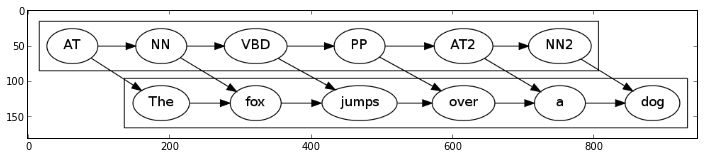

In [138]:
open("hmm1.dot","w").write("""
digraph hmm1 {
rankdir = "LR";
subgraph cluster_labels {
AT -> NN -> VBD -> PP -> AT2 -> NN2;
}
subgraph cluster_text {
The -> fox -> jumps -> over -> a -> dog;
}
AT -> The; NN -> fox; VBD -> jumps; PP -> over; AT2 -> a; NN2 -> dog;
}
""")
!dot -Tpng hmm1.dot -o hmm1.png
figsize(12,5)
imshow(imread("hmm1.png"))

If we use the tags as identities for the hidden states, we obtain this
Hidden Markov Model corresponding to a bigram tagger.

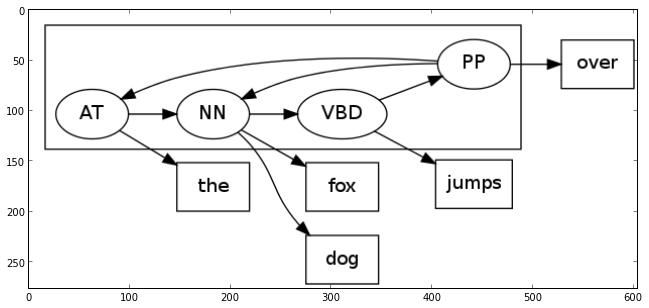

In [132]:
open("hmm2.dot","w").write("""
digraph hmm2 {
rankdir = "LR";
subgraph cluster_states {
AT -> NN -> VBD -> PP -> NN;
PP -> AT;
}
AT -> the;
NN -> fox;
NN -> dog;
VBD -> jumps;
PP -> over;
the [shape=record];
fox [shape=record];
dog [shape=record];
jumps [shape=record];
over [shape=record];
}
""")
!dot -Tpng hmm2.dot -o hmm2.png
figsize(12,5)
imshow(imread("hmm2.png"))

So, in this equivalence between n-gram taggers and Hidden Markov Models, we view...

- each tag becomes a hidden state
- words are the symbols emitted from each state

Note that this is an odd kind of model, because the "hidden" state isn't really hidden
at all, it's the label sequence we want to infer based on the word sequence.

For a trigram tagger, the hidden states become pairs of tags, representing the two previous tags, and state transitions are constrained so that "(U,V)" can only transition to "(V,X)".

Of course, these n-gram hidden states are really just a finite state
approximation to a natural language grammar expressed using the tags
as non-terminal symbols, and using a simple probabilistic model
for the non-terminal to terminal mappings.

# Weighted Finite State Transducers

A more general model in which the "hidden states" actually deserve their name is a
*transducer*. In a transducer, each hidden state has both a distribution of
input symbols and a distribution of output symbols.

This might make a big differnce, since the statistics of tags and words may depend on the position in a sentence. That is, there might be multiple "AT" nodes for different positions
in the sentence.

The usual way of representing this is as *weighted finite state transducers*.
In a weighted finite state transducer, we put input and output symbols on the
edges, not the states.

Here is a simple illustration of this:

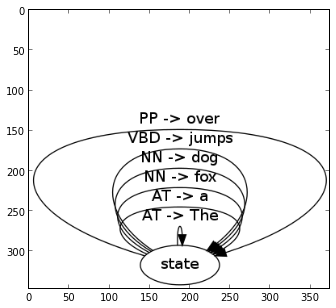

In [134]:
open("hmm3.dot","w").write("""
digraph hmm3 {
rankdir = "LR";
state -> state [label="AT -> The"];
state -> state [label="AT -> a"];
state -> state [label="NN -> fox"];
state -> state [label="NN -> dog"];
state -> state [label="VBD -> jumps"];
state -> state [label="PP -> over"];
}
""")
!dot -Tpng hmm3.dot -o hmm3.png
figsize(12,5)
imshow(imread("hmm3.png"))

We can now introduce more complicated state structures.

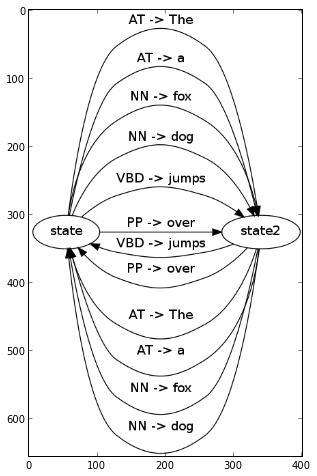

In [136]:
open("hmm3.dot","w").write("""
digraph hmm3 {
rankdir = "LR";
state -> state2 [label="AT -> The"];
state -> state2 [label="AT -> a"];
state -> state2 [label="NN -> fox"];
state -> state2 [label="NN -> dog"];
state -> state2 [label="VBD -> jumps"];
state -> state2 [label="PP -> over"];
state2 -> state [label="AT -> The"];
state2 -> state [label="AT -> a"];
state2 -> state [label="NN -> fox"];
state2 -> state [label="NN -> dog"];
state2 -> state [label="VBD -> jumps"];
state2 -> state [label="PP -> over"];
}
""")
!dot -Tpng hmm3.dot -o hmm3.png
figsize(12,8)
imshow(imread("hmm3.png"))

For the simple n-gram taggers, the "hidden" state sequence was trivially given by the tag sequence.

Weighted finite state transducers offer a lot more power. How are we going to use this power?

One way we may be able to use this power is to do the following:

- write down a full natural language grammar
- approximate this grammar using finite state models
- translate into a finite state transducer representing the non-terminals (labels) and terminals (words)